In [89]:
from datetime import date

import openfisca_france
from openfisca_france.model.base import *

# to debug / trace
from openfisca_core import web_tools

## Adaptation pour faciliter l'usage de ce notebook

_Ce correctif permet de redéfinir plusieurs fois la même variable sans provoquer d'erreur._

In [90]:
import functools

from openfisca_france.entities import entity_class_by_symbol

# Système socio-fiscal

In [91]:
tax_benefit_system = openfisca_france.init_tax_benefit_system()

In [92]:
from openfisca_core import reforms

In [93]:
ReformeRevenuDeBase = reforms.make_reform(
    key = 'reforme_rdb',
    name = u"Réforme Revenu de base",
    reference = tax_benefit_system,
    )

# Réforme : 1. Revenu de base

In [94]:
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_
#- Hausse de la CSG déductible au taux de 25%
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire
#- Intégrer le revenu de base au revenu disponible
#- Mise en place d'un crédit d'impot familles monoparentales montant ??? (50€)
#- Supprimer le RSA


#-Visualisation graphique en abscisse salaire brut et en ordonnée variation du revenu disponible 
# pour un célibataire sans enfant
# pour un couple sans enfant
# une famille monoparentale


#(- Nouveau calcul de l'IRPP)


In [95]:
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
import json
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
def modify_legislation_json(reference_legislation_json_copy):
    for value_json in reference_legislation_json_copy['children']['csg']['children']['activite']['children']['deductible']['children']['taux']['values']:
        value_json['value'] = 0.20
    return reference_legislation_json_copy



In [96]:
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire

class rdb(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age') 
        rmi = simulation.legislation_at(period.start).minim.rmi
        
        return period, ((age >= 18) * rmi.rmi * ( 1 -rmi.forfait_logement.taux1) + not_(age >= 18) * 0)



In [97]:
    # On enlève les enfants du calcul du nbptr (quotient_familial.enf*)
class nbptr(ReformeRevenuDeBase.Variable):
        reference = FoyersFiscaux.column_by_name['nbptr']

    
    
    def function(self, simulation, period):
        '''
        Nombre de parts du foyer
        'foy'
        note 1 enfants et résidence alternée (formulaire 2041 GV page 10)

        quotient_familial.conj : nb part associées au conjoint d'un couple marié ou pacsé
        quotient_familial.enf1 : nb part 2 premiers enfants
        quotient_familial.enf2 : nb part enfants de rang 3 ou plus
        quotient_familial.inv1 : nb part supp enfants invalides (I, G)
        quotient_familial.inv2 : nb part supp adultes invalides (R)
        quotient_familial.not31 : nb part supp note 3 : cases W ou G pour veuf, celib ou div
        quotient_familial.not32 : nb part supp note 3 : personne seule ayant élevé des enfants
        quotient_familial.not41 : nb part supp adultes invalides (vous et/ou conjoint) note 4
        quotient_familial.not42 : nb part supp adultes anciens combattants (vous et/ou conjoint) note 4
        quotient_familial.not6 : nb part supp note 6
        quotient_familial.isol : demi-part parent isolé (T)
        quotient_familial.edcd : enfant issu du mariage avec conjoint décédé;
        '''
        period = period.start.offset('first-of', 'month').period('year')
        nb_pac = simulation.calculate('nb_pac', period)
        marpac = simulation.calculate('marpac', period)
        celdiv = simulation.calculate('celdiv', period)
        veuf = simulation.calculate('veuf', period)
        jveuf = simulation.calculate('jveuf', period)
        nbF = simulation.calculate('nbF', period)
        nbG = simulation.calculate('nbG', period)
        nbH = simulation.calculate('nbH', period)
        nbI = simulation.calculate('nbI', period)
        nbR = simulation.calculate('nbR', period)
        nbJ = simulation.calculate('nbJ', period)
        caseP = simulation.calculate('caseP', period)
        caseW = simulation.calculate('caseW', period)
        caseG = simulation.calculate('caseG', period)
        caseE = simulation.calculate('caseE', period)
        caseK = simulation.calculate('caseK', period)
        caseN = simulation.calculate('caseN', period)
        caseF = simulation.calculate('caseF', period)
        caseS = simulation.calculate('caseS', period)
        caseL = simulation.calculate('caseL', period)
        caseT = simulation.calculate('caseT', period)
        quotient_familial = simulation.legislation_at(period.start).ir.quotient_familial

        no_pac = nb_pac == 0  # Aucune personne à charge en garde exclusive
        has_pac = not_(no_pac)
        no_alt = nbH == 0  # Aucun enfant à charge en garde alternée
        has_alt = not_(no_alt)

        # # nombre de parts liées aux enfants à charge
        # que des enfants en résidence alternée
        enf1 = (no_pac & has_alt) * (quotient_familial.enf1 * min_(nbH, 2) * 0.5
                                     + quotient_familial.enf2 * max_(nbH - 2, 0) * 0.5)
        # pas que des enfants en résidence alternée
        enf2 = (has_pac & has_alt) * ((nb_pac == 1) * (quotient_familial.enf1 * min_(nbH, 1) * 0.5
            + quotient_familial.enf2 * max_(nbH - 1, 0) * 0.5) + (nb_pac > 1) * (quotient_familial.enf2 * nbH * 0.5))
        # pas d'enfant en résidence alternée
        enf3 = quotient_familial.enf1 * min_(nb_pac, 2) + quotient_familial.enf2 * max_((nb_pac - 2), 0)

        enf = enf1 + enf2 + enf3
        # # note 2 : nombre de parts liées aux invalides (enfant + adulte)
        n2 = quotient_familial.inv1 * (nbG + nbI / 2) + quotient_familial.inv2 * nbR

        # # note 3 : Pas de personne à charge
        # - invalide

        n31a = quotient_familial.not31a * (no_pac & no_alt & caseP)
        # - ancien combatant
        n31b = quotient_familial.not31b * (no_pac & no_alt & (caseW | caseG))
        n31 = max_(n31a, n31b)
        # - personne seule ayant élevé des enfants
        n32 = quotient_familial.not32 * (no_pac & no_alt & ((caseE | caseK) & not_(caseN)))
        n3 = max_(n31, n32)
        # # note 4 Invalidité de la personne ou du conjoint pour les mariés ou
        # # jeunes veuf(ve)s
        n4 = max_(quotient_familial.not41 * (1 * caseP + 1 * caseF), quotient_familial.not42 * (caseW | caseS))

        # # note 5
        #  - enfant du conjoint décédé
        n51 = quotient_familial.cdcd * (caseL & ((nbF + nbJ) > 0))
        #  - enfant autre et parent isolé
        n52 = quotient_familial.isol * caseT * (((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2))) + 1 * has_pac)
        n5 = max_(n51, n52)

        # # note 6 invalide avec personne à charge
        n6 = quotient_familial.not6 * (caseP & (has_pac | has_alt))

        # # note 7 Parent isolé
        n7 = quotient_familial.isol * caseT * ((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2)) + 1 * has_pac)

        # # Régime des mariés ou pacsés
        #m = 1 + quotient_familial.conj + enf + n2 + n4
        m = 1 + quotient_familial.conj + n2 + n4
        
        # # veufs  hors jveuf
     # v = 1 + enf + n2 + n3 + n5 + n6
        v = 1 + n2 + n3 + n5 + n6
        
        # # celib div
        #c = 1 + enf + n2 + n3 + n6 + n7
        c = 1 + n2 + n3 + n6 + n7

        return period, (marpac | jveuf) * m + (veuf & not_(jveuf)) * v + celdiv * c


In [98]:
# Suppression des allocations familiales

class af(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['af']

    def function(self, simulation, period):
        period = period.this_month
        af_base = simulation.calculate('af_base', period)
        af_majo = simulation.calculate('af_majo', period)
        af_forf = simulation.calculate('af_forf', period)

        #return period, af_base + af_majo + af_forf
        return period, af_base * 0

In [99]:
from numpy import round

# Suppression du complément familial

class cf(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['cf']

    def function(self, simulation, period):
        '''
        L'allocation de base de la paje n'est pas cumulable avec le complément familial
        '''
        period = period.this_month
        paje_base = simulation.calculate('paje_base', period)
        apje_temp = simulation.calculate('apje_temp', period)
        ape_temp = simulation.calculate('ape_temp', period)
        cf_montant = simulation.calculate('cf_montant', period)
        residence_mayotte = simulation.calculate('residence_mayotte', period)

        cf_brut = not_(paje_base) * (apje_temp <= cf_montant) * (ape_temp <= cf_montant) * cf_montant
        # return period, not_(residence_mayotte) * round(cf_brut, 2)
        return period, not_(residence_mayotte) * round(cf_brut, 2) * 0

In [100]:

# Suppression de l'allocation de rentrée scolaire

class ars(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['ars']

    def function(self, simulation, period):
        '''
        Allocation de rentrée scolaire brute de CRDS
        '''
        period_br = period.this_year
        return period_br, self.zeros()

In [101]:
# Suppression de la cotisation patronale famille 

class famille(ReformeRevenuDeBase.Variable):
    reference = Individus.column_by_name['famille']

    def function(self, simulation, period):
        # cotisation = apply_bareme(
        #    simulation,
        #    period,
        #    cotisation_type = 'employeur',
        #    bareme_name = 'famille',
        #    variable_name = self.__class__.__name__,
        #    )
        #return period, cotisation        
        return period, self.zeros()

In [102]:
# Création d'un revenu de base enfant - Version individus au niveau des allocations familliales actuelles

class rdb_enf(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base enfant"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age')
        P = simulation.legislation_at(period.start).fam.af        
        bmaf = P.bmaf
        
        return period, ((age < 14) * 0.41 + not_(age < 14) * 0.57) * bmaf * (age <= 18)

In [103]:
#- Mise en place d'un crédit d'impot familles monoparentales montant (150€)
class credit_impot_monoparentales(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Menages
    label = u"credit_impot_monoparentales"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        nb_enf_a_charge = simulation.calculate('nombre_enfants_a_charge_menage',period)
        caseT = simulation.calculate('caseT',period) #Egal True si le parent est isolé
      
        
        #return period, or_(and_(age_holder >= 18, nb_enf_a_charge > 0, caseT), or_(age_holder < 18, nb_enf_a_charge <= 0, not_(caseT)) * 0) * 100
        return period, (nb_enf_a_charge > 0) * (caseT) * 150
    #Si le parent est isolé, avec au moins un enfant, et qu'il est majeur il reçoit la pension

In [104]:
#- Supprimer le RSA
class rsa_socle(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['rsa_socle']

    def function(self, simulation, period):
        period = period.this_month
        nb_par = simulation.calculate('nb_par', period)
        eligib = simulation.calculate('rsa_eligibilite', period)
        nb_enfant_rsa = simulation.calculate('nb_enfant_rsa', period)
        rmi = simulation.legislation_at(period.start).minim.rmi

        nbp = nb_par + nb_enfant_rsa

        taux = (
            1 +
            (nbp >= 2) * rmi.txp2 +
            (nbp >= 3) * rmi.txp3 +
            (nbp >= 4) * ((nb_par == 1) * rmi.txps + (nb_par != 1) * rmi.txp3) +
            max_(nbp - 4, 0) * rmi.txps
        )
        #on met à zéro
        return period, eligib * rmi.rmi * taux * 0

In [105]:
#- Intégrer le revenu de base au revenu disponible
class revdisp(ReformeRevenuDeBase.Variable):
    reference = Menages.column_by_name['revdisp']

    def function(self, simulation, period):
        '''
        Revenu disponible - ménage
        'men'
        '''
        period = period.start.period('year').offset('first-of')
        rev_trav_holder = simulation.compute('rev_trav', period)
        pen_holder = simulation.compute('pen', period)
        rev_cap_holder = simulation.compute('rev_cap', period)
        psoc_holder = simulation.compute('psoc', period)
        ppe_holder = simulation.compute('ppe', period)
        impo = simulation.calculate('impo', period)
        rdb_holder = simulation.calculate_add('rdb', period)
        credit_impot_familles_holder = simulation.calculate_add('credit_impot_monoparentales', period)
        rdb_enf_holder = simulation.calculate_add('rdb_enf', period)

        pen = self.sum_by_entity(pen_holder)
        ppe = self.cast_from_entity_to_role(ppe_holder, role = VOUS)
        ppe = self.sum_by_entity(ppe)
        psoc = self.cast_from_entity_to_role(psoc_holder, role = CHEF)
        psoc = self.sum_by_entity(psoc)
        rev_cap = self.sum_by_entity(rev_cap_holder)
        rev_trav = self.sum_by_entity(rev_trav_holder)
        rdb = self.sum_by_entity(rdb_holder)
        rdb_enf = self.sum_by_entity(rdb_enf_holder)
        
        return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_familles_holder + rdb_enf

# Tests

In [106]:
reform = ReformeRevenuDeBase()
reform.modify_legislation_json(modifier_function = modify_legislation_json)

In [107]:
parent1_salaire_de_base = 20000

In [108]:
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [
        dict(
            birth = date(2010, 1, 1),
        ),
    ],
    )
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [59]:
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [
        dict(
            birth = date(2010, 1, 1),
        ),
    ],
    )
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

Calculs de référence (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [109]:
simulation_ref_individu_seul.calculate('revdisp')

array([ 19701.80859375], dtype=float32)

In [110]:
simulation_rdb_individu_seul.calculate_add('rdb_enf')

array([    0.        ,  1995.57678223], dtype=float32)

In [111]:
simulation_ref_individu_seul.calculate_add('rsa')

array([ 2185.00927734], dtype=float32)

In [112]:
simulation_ref_individu_seul.calculate('csg_imposable_salaire')

array([-471.59909058,   -0.        ], dtype=float32)

In [113]:
simulation_ref_individu_seul.calculate('csg_deductible_salaire')

array([-1002.14794922,    -0.        ], dtype=float32)

In [114]:
simulation_ref_individu_seul.calculate('tot_impot')

array([ 1588.60412598], dtype=float32)

Calculs avec réforme RDB (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [115]:
simulation_rdb_individu_seul.calculate('revdisp')

array([ 23494.22265625], dtype=float32)

In [116]:
simulation_rdb_individu_seul.calculate('irpp')

array([ 0.], dtype=float32)

In [117]:
simulation_rdb_individu_seul.calculate('csg_deductible_salaire')

array([-3929.99145508,    -0.        ], dtype=float32)

In [118]:
simulation_rdb_individu_seul.calculate('tot_impot')

array([ 4505.52246094], dtype=float32)

In [119]:
# trace
simulation_rdb_individu_seul.calculate('tot_impot')
#print web_tools.get_trace_tool_link(scenario, ['tot_impot'])

array([ 4505.52246094], dtype=float32)

## Graphiques: scenario variant selon salaire_de_base (0 => 60k par palier de 5k)
nb_pla = 5000
min_salaire_de_base = 0
max_salaire_de_base = 60000

In [120]:
min_salaire_de_base = 0
max_salaire_de_base = 60000
nb_palier = max_salaire_de_base / 5000

In [121]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
def make_two_parents_scenario(nombre_enfants = 1, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            birth = date(1980, 1, 1),
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation = 4,
            ),
        )
    return scenario

In [123]:
scenario_alone_ref = make_two_parents_scenario(0, 2014)
simulation_alone_ref = scenario_alone_ref.new_simulation()

In [124]:
scenario_alone_rdb = make_two_parents_scenario(0, 2014, reform)
simulation_alone_rdb = scenario_alone_reform.new_simulation()

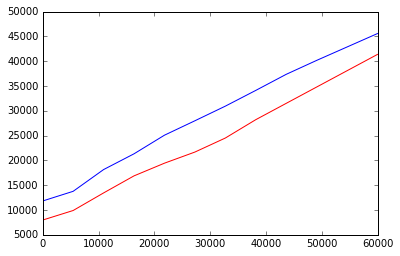

In [129]:
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_couple_ref = simulation_alone_ref.calculate_add("revdisp")
revenu_disponible_couple_rdb = simulation_alone_rdb.calculate_add("revdisp")

salaire_de_base_couple_ref = simulation_alone_ref.calculate("salaire_de_base")
salaire_de_base_couple_rdb = simulation_alone_rdb.calculate("salaire_de_base")

plt.plot(salaire_de_base_couple_bis, revenu_disponible_couple_ref, 'r', salaire_de_base_couple_bis, revenu_disponible_couple_rdb, label='q')